In [28]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from sklearn.datasets import load_iris

# load the iris dataset
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

In [30]:
from sklearn.preprocessing import MinMaxScaler

# scale the features to be between 0 and 1
features = MinMaxScaler().fit_transform(features)

In [31]:
# Reduce it to a binary classification problem, by merging labels 1 and 2
reduced_labels  = [1 if l == 2 else l for l in labels]

C:\Users\Dimitri\workspaces\opensource\quantum-computing\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


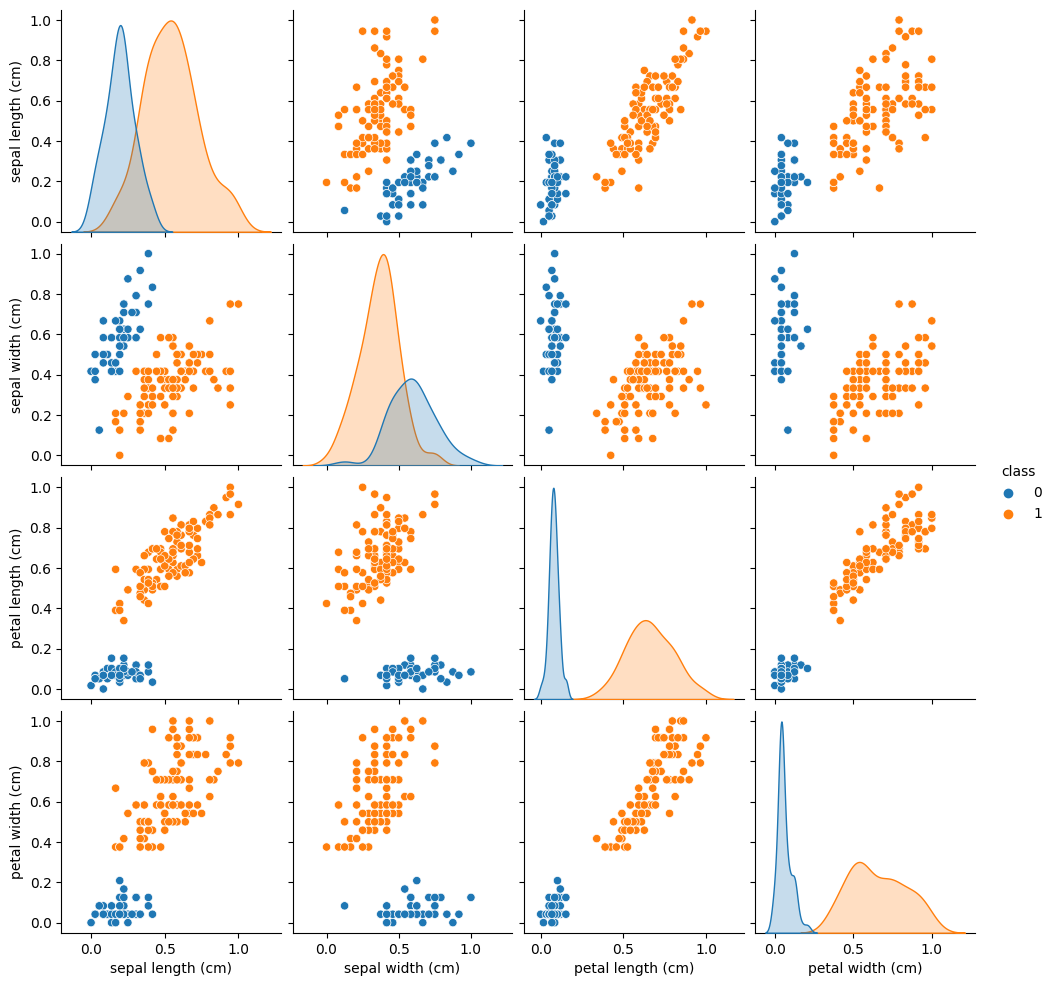

In [32]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(features, columns=iris_data.feature_names)
df["class"] = pd.Series(reduced_labels)

sns.pairplot(df, hue="class", palette="tab10")

C:\Users\Dimitri\workspaces\opensource\quantum-computing\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


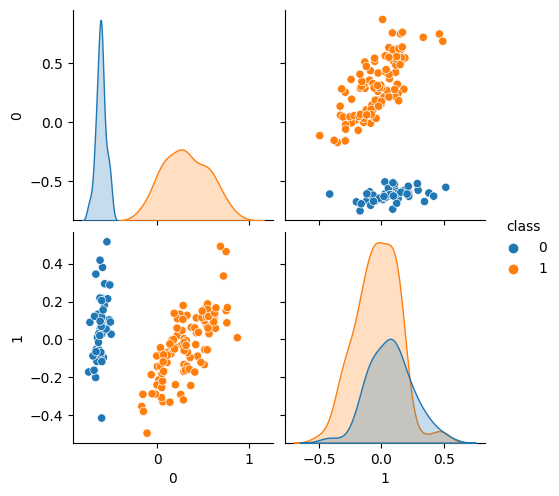

In [33]:
# To make the problem even simpler, reduce the dimension of the space to 2 using PCA

from sklearn.decomposition import PCA

reduced_features = PCA(n_components=2).fit_transform(features)

df = pd.DataFrame(reduced_features)
df["class"] = pd.Series(reduced_labels)

sns.pairplot(df, hue="class", palette="tab10")

In [34]:
# Train/test split
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

# set the seed
algorithm_globals.random_seed = 123

train_features, test_features, train_labels, test_labels = train_test_split(
    reduced_features, reduced_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


In [36]:
# Train classically with built-in classifier

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

classifier = LinearSVC(dual="auto")
classifier.fit(train_features, train_labels)
accuracy_score(test_labels, classifier.predict(test_features))

1.0

# Variational QML

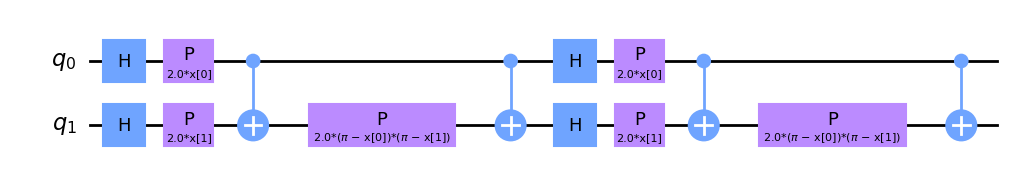

In [37]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

# classical to quantum data encoding
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)

FEATURE_MAP.decompose().draw(output='mpl')

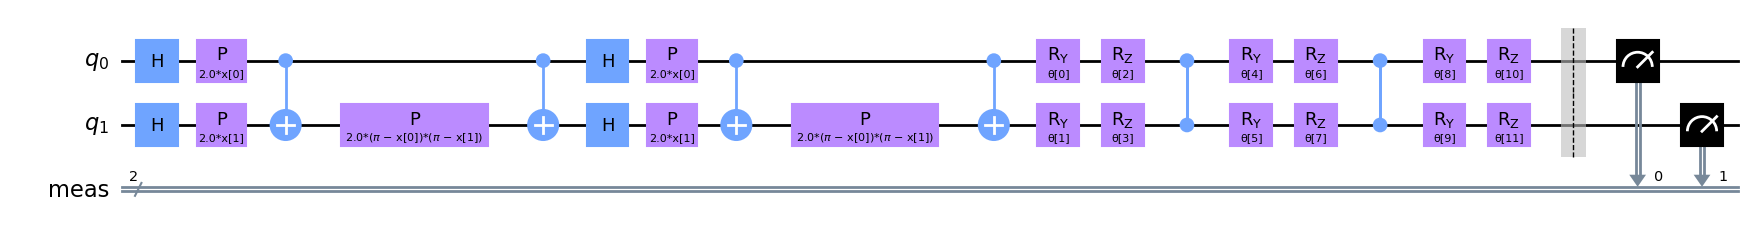

In [38]:
# classification model (ansatz)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw(output='mpl')

In [39]:
def assign_params(data, weights):
    """
    Assign a data point and a set of "weights" to the circuit to create a concrete implementation
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = weights[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

In [40]:
from qiskit import BasicAer, execute
from qml.classification import label_probability


def execute_circuit(data, weights):
    # create a instance of the circuit for every data point 
    circuits = [assign_params(d, weights) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    return [label_probability(results.get_counts(c)) for c in circuits]


In [41]:
from qml.classification import cross_entropy_loss

def cost_function(data, labels, weights):
    classifications = execute_circuit(data, weights)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

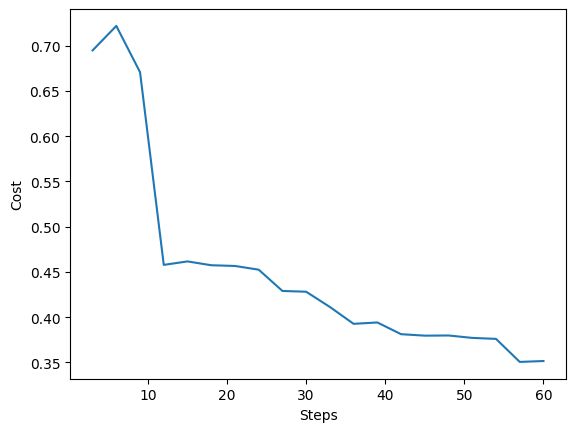

In [42]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA
from qml.classification import OptimizerLog

log = OptimizerLog()
optimizer = SPSA(maxiter=20, callback=log.update)

initial_point = np.random.random(VAR_FORM.num_parameters)

# Run the optimization
result = optimizer.minimize(lambda w: cost_function(train_features, train_labels, w), initial_point)
opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

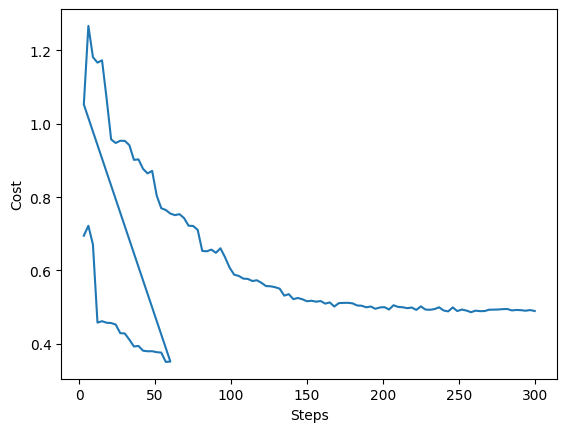

In [43]:
# Now try the built-in classifier

# First we need to one-hot encode the labels

from numpy import reshape
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_labels_oh = encoder.fit_transform(reshape(train_labels, (-1, 1))).toarray()
test_labels_oh = encoder.fit_transform(reshape(test_labels, (-1, 1))).toarray()

from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(train_features, train_labels_oh)

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()